# Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from xgboost import XGBClassifier, plot_importance

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [7]:
def balanced_recall_accuracy(y_true, y_pred, alpha=0.7):
    recall_class1 = recall_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return alpha * recall_class1 + (1 - alpha) * accuracy  # Weighted sum

In [8]:
def constrained_recall_scorer(y_true, y_pred):
    recall_0 = recall_score(y_true, y_pred, pos_label=0)  # Recall for Class 0
    accuracy = accuracy_score(y_true, y_pred)
    
    # Penalize if Class 0 recall < 0.6, else reward accuracy
    if recall_0 < 0.6:
        return -1  # Invalid solution (heavily penalized)
    else:
        return accuracy  # Or combine with Class 1 recall: (recall_0 + recall_score(y_true, y_pred, pos_label=1)) / 2

# Import data

In [9]:
# 1. Définir la cible
target1 = 'AccumulationInvestment'

df_clients = pd.read_excel("df_accumulation.xlsx", sheet_name="ProcessedData")
df_products = pd.read_excel("Dataset2_Needs.xls", sheet_name="Products")

X = df_clients.drop(columns=[target1])
y = df_clients[target1]
X.head()

,Age,FinancialEducation,Income,Wealth
0,60,0.228685,68.181525,53.260067
1,78,0.358916,21.807595,135.550048
2,33,0.317515,23.252747,66.303678
3,69,0.767685,166.189034,404.997689
4,58,0.429719,21.186723,58.911930


In [10]:
df_clients_transformed = pd.read_excel("df_accumulation_preprocessed.xlsx", sheet_name="ProcessedData")
X_transformed = df_clients_transformed.drop(columns=[target1])
y_transformed = df_clients_transformed[target1]
X_transformed.head()

,Age,FinancialEducation,Income,Wealth
0,0.3125,-0.873326,0.253488,-0.193803
1,1.4375,-0.268517,-0.786332,0.681875
2,-1.3750,-0.460788,-0.736832,0.003208
3,0.8750,1.629849,1.345268,1.828994
4,0.1875,0.060300,-0.808293,-0.103730


In [11]:
# Initialize a completely empty DataFrame
nba = pd.DataFrame()

# Logistic Regression

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)

In [13]:
custom_scorer = make_scorer(constrained_recall_scorer)

In [ ]:
# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0:1, 1:2}, {0:1, 1:3}],
    'l1_ratio': [0.1, 0.5, 0.9],  # For elasticnet only
    'max_iter': [500],  # Single large-enough value
    'tol': [1e-4]  # Single standard value
}

# Initialize and fit
lr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best params:", grid_search.best_params_)

C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when pena

KeyboardInterrupt: 

In [15]:
best_params = grid_search.best_params_

# 3. Modèle
log_reg = LogisticRegression(**best_params)
log_reg.fit(X_train, y_train)

# 4. Prédictions
y_pred_test = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X)[:, 1]  # probabilité sur l'ensemble

# 5. Rapport de classification
print(f"\n📊 Résultats pour : {target1}")
print("-" * 40)
print(classification_report(y_test, y_pred_test))

# 6. Stockage des probabilités dans df_clients
nba[f'reg_log_{target1}_proba'] = y_pred_proba

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# XGB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 1. Split training data into train/validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train
)

# 1. Define the refined parameter grid
param_grid = {
    # Tightened around best values (±1-2 steps)
    'max_depth': [4, 5, 6],                          # Best was 5
    'min_child_weight': [2, 3, 4],                   # Best was 3
    'gamma': [0.15, 0.2, 0.25],                      # Best was 0.205
    'learning_rate': [0.08, 0.1, 0.12],              # Best was 0.1
    'n_estimators': [80, 90, 100, 110],              # Best was 93
    'subsample': [0.9, 1.0],                         # Best was 1.0
    'colsample_bytree': [0.8, 0.9, 1.0],             # New (wasn't in original)
    'reg_alpha': [0, 0.5, 1],                        # New regularization
    'reg_lambda': [0, 0.5, 1],                       # New regularization
    'scale_pos_weight': [1, 2]                       # Best was 1
}

# 2. Initialize XGBoost with your custom scorer
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    early_stopping_rounds=10,
    n_jobs=-1,
    random_state=42
)

# 3. Configure GridSearchCV
search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,                                           # Faster than cv=5
    scoring=make_scorer(balanced_recall_accuracy),   # Your custom scorer
    verbose=3,                                      # Detailed logging
    n_jobs=-1,                                      # Use all cores
    refit=True                                      # Retrain best model
)

# 4. Run the search (target: 10-15 mins)
search.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],                      # For early stopping
    verbose=False
)

Fitting 5 folds for each of 34992 candidates, totalling 174960 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=...
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0.15, 0.2, 0.25],
                         'learning_rate': [0.08, 0.1, 0.12],
                         'max_depth': [4, 5, 6], 'min_child_weight': [2, 3, 4],
                         'n_estimators': [80, 90, 100, 110],
                         'reg_alpha': [0, 0.5, 1], 'reg_lambda': [0, 0.5, 1],
                         'scale_pos_weight': [1, 2], 'subsample': [0.9, 1.0]},
             scoring=make_scorer(balanced_recall_accuracy, response_method='predict'),
             verbose=3)

In [ ]:
best_params = search.best_params_
print("Best parameters:", best_params)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 90, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 2, 'subsample': 0.9}



Training XGBoost for: AccumulationInvestment

Classification Report :
               precision    recall  f1-score   support

           0       0.79      0.70      0.74       489
           1       0.74      0.83      0.78       511

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000

ROC AUC Score : 0.8536


<Figure size 1000x600 with 0 Axes>

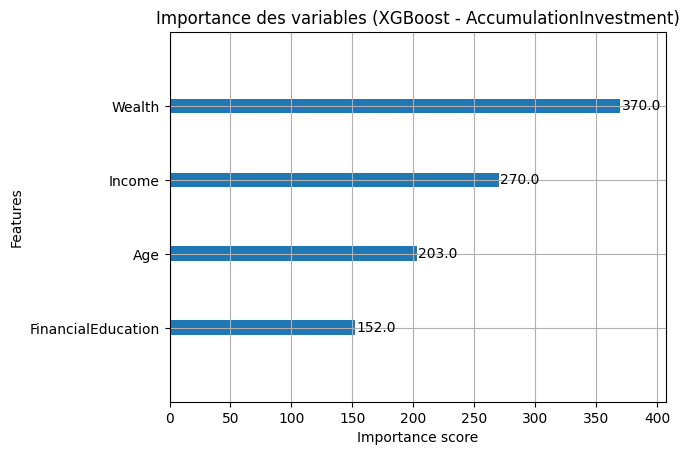

In [ ]:
print(f"\nTraining XGBoost for: {target}")
print("=" * 50)
  
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Évaluation
print("\nClassification Report :\n", classification_report(y_test[target], y_pred))
print(f"ROC AUC Score : {roc_auc_score(y_test[target], y_proba):.4f}")

# Affichage des features
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title(f"Importance des variables (XGBoost - {target})")
plt.show()

# Random Forest

In [ ]:
param_grid = {
    # Core parameters
    'n_estimators': [50, 100, 150],            # Fewer trees than XGBoost
    'max_depth': [3, 5, 7, None],              # None = unlimited
    'min_samples_split': [2, 5, 10],           # Control overfitting
    'min_samples_leaf': [1, 2, 4],
    
    # Imbalance handling (critical for your recall goals)
    'class_weight': [
        None, 
        'balanced', 
        {0:1, 1:2},  # Penalize class 1 errors more
        {0:1, 1:3}
    ],
    
    # Randomness and diversity
    'max_features': ['sqrt', 0.8, None],       # Feature subsampling
    'bootstrap': [True, False]                  # With/without replacement
}

# 2. Initialize with your custom scorer
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1  # Use all cores
)

# 3. Configure GridSearchCV
search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                                      # Faster than cv=5
    scoring=custom_scorer,  # Your custom metric
    verbose=3,                                 # Detailed logging
    n_jobs=-1                                  # Parallelize
)

# 4. Run search (~20 mins)
search.fit(X_train, y_train)  # No early stopping needed for RF

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced', {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'max_depth': [3, 5, 7, None],
                         'max_features': ['sqrt', 0.8, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(constrained_recall_scorer, response_method='predict'),
             verbose=3)

In [ ]:
best_params = search.best_params_
print("Best Parameters:", best_params)
best_rf = search.best_estimator_  # Already trained with best params
# Predictions
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]  # Class 1 probabilities

# Metrics
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

# Verify your custom constraints
recall_class0 = recall_score(y_test, y_pred, pos_label=0)
recall_class1 = recall_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

print(f"Class 0 Recall: {recall_class0:.3f} (≥0.6)")
print(f"Class 1 Recall: {recall_class1:.3f}")
print(f"Accuracy: {accuracy:.3f} (≥0.7)")

Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Test Set Performance:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       489
           1       0.86      0.75      0.80       511

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000

Class 0 Recall: 0.875 (≥0.6)
Class 1 Recall: 0.750
Accuracy: 0.811 (≥0.7)


In [ ]:
# Grille des hyperparamètres
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

for target in targets:
    print(f"\n🔍 GridSearchCV Random Forest for: {target}")
    print("=" * 50)

    # Split (à nouveau pour la bonne target)
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)

    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

    grid_search_rf = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid_rf,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid_search_rf.fit(X_train, y_train)
    print("🌟 Meilleurs paramètres :", grid_search_rf.best_params_)

    best_rf = grid_search_rf.best_estimator_

    # Évaluation
    y_pred_rf = best_rf.predict(X_test)
    y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

    
    print("\nClassification Report :")
    print(classification_report(y_test, y_pred_rf))
    print(f"ROC AUC : {roc_auc_score(y_test, y_proba_rf):.4f}")

    # Ajout des prédictions optimisées au DataFrame
    df_clients[f'rf_proba_{target}'] = best_rf.predict_proba(X)[:, 1]



🔍 GridSearchCV Random Forest for: AccumulationInvestment
Fitting 3 folds for each of 48 candidates, totalling 144 fits
🌟 Meilleurs paramètres : {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report :
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       489
           1       0.82      0.73      0.77       511

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.79      0.78      0.78      1000

ROC AUC : 0.8311



Training Random Forest for: AccumulationInvestment

Classification Report :
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       489
           1       0.82      0.73      0.77       511

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000

ROC AUC : 0.8297


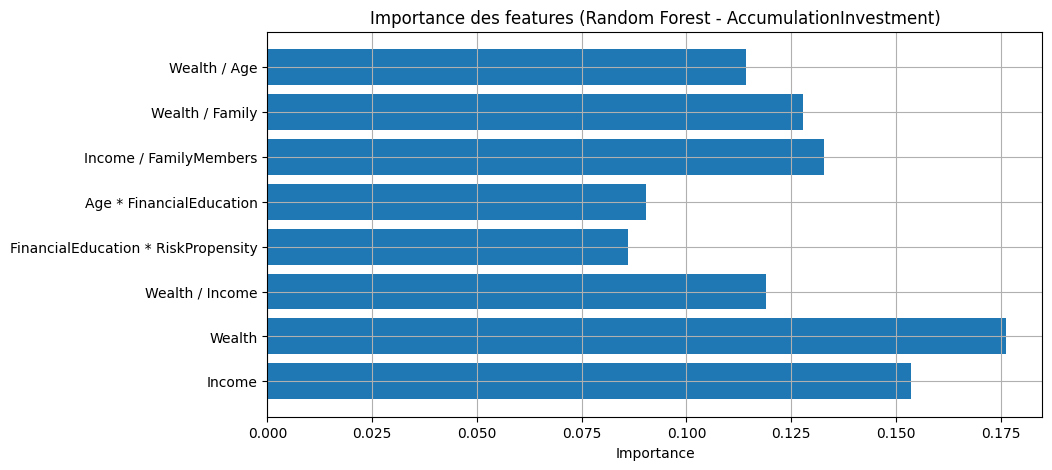

In [ ]:
for target in targets:
    print(f"\nTraining Random Forest for: {target}")
    print("=" * 50)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)

    # Modèle de base
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    # Évaluation
    y_pred_rf = rf_model.predict(X_test)
    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

    print("\nClassification Report :")
    print(classification_report(y_test, y_pred_rf))
    print(f"ROC AUC : {roc_auc_score(y_test, y_proba_rf):.4f}")

    # Importance des variables
    importances = rf_model.feature_importances_
    feat_names = X.columns

    plt.figure(figsize=(10, 5))
    plt.barh(feat_names, importances)
    plt.title(f"Importance des features (Random Forest - {target})")
    plt.xlabel("Importance")
    plt.grid(True)
    plt.show()

    

# Neural Network

In [ ]:
# Custom dataset class
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Val Loss: {val_loss/len(val_loader):.4f}, '
                  f'Val Accuracy: {accuracy_score(val_true, val_preds):.4f}')

# Model evaluation
def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())
            all_true.extend(y_batch.numpy())

    return {
        'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds),
        'recall': recall_score(all_true, all_preds),
        'f1': f1_score(all_true, all_preds)
    }

In [ ]:
for target in targets:
    print(f"\nTraining MLP for: {target}")
    print("=" * 50)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)

    # Préparation des datasets
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialiser modèle, loss, optimizer
    model = MLP(input_size=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraînement (tu peux remplacer par train_model_with_curves)
    train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50)

    # Get metrics
    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    # Display results
    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)


Training MLP for: AccumulationInvestment
Epoch 10, Train Loss: 0.5549, Val Loss: 0.4953, Val Accuracy: 0.7750
Epoch 20, Train Loss: 0.5358, Val Loss: 0.4725, Val Accuracy: 0.7810
Epoch 30, Train Loss: 0.5312, Val Loss: 0.4611, Val Accuracy: 0.7940
Epoch 40, Train Loss: 0.5132, Val Loss: 0.4503, Val Accuracy: 0.7920
Epoch 50, Train Loss: 0.5075, Val Loss: 0.4510, Val Accuracy: 0.7900

Neural Network Metrics:
           Training   Test
accuracy      0.802  0.790
precision     0.890  0.868
recall        0.700  0.695
f1            0.784  0.772


In [ ]:
# Enhanced MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Training with learning rate scheduler
def train_model_with_curves(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        # Store metrics
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(accuracy_score(val_true, val_preds))

        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'Val Accuracy: {val_accuracies[-1]:.4f}')

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Let's modify the Investment Dataset class to handle both Pandas and PyTorch
class InvestmentDatasetFixed(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        # Check if y is already a tensor or needs to be converted
        if isinstance(y, torch.Tensor):
            self.y = y
        else:
            self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to get predictions from the enhanced MLP model (i.e., the last estimated one)
def get_predictions_from_mlp(model, X_test):
    # Create a dataset and dataloader for predictions
    dummy_y = pd.Series(np.zeros(len(X_test)))  # Creating a Panda series
    test_dataset = InvestmentDatasetFixed(X_test, dummy_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Get predictions
    model.eval()
    all_preds = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())

    return np.array(all_preds)


Training Enhanced MLP for: AccumulationInvestment
Epoch 10, Train Loss: 0.5408, Val Loss: 0.4675, Val Accuracy: 0.7870
Epoch 20, Train Loss: 0.5363, Val Loss: 0.4665, Val Accuracy: 0.7960
Epoch 30, Train Loss: 0.5257, Val Loss: 0.4612, Val Accuracy: 0.7970
Epoch 40, Train Loss: 0.5148, Val Loss: 0.4497, Val Accuracy: 0.7970
Epoch 50, Train Loss: 0.5233, Val Loss: 0.4593, Val Accuracy: 0.7940
Epoch 60, Train Loss: 0.5099, Val Loss: 0.4525, Val Accuracy: 0.7890
Epoch 70, Train Loss: 0.5110, Val Loss: 0.4467, Val Accuracy: 0.8000
Epoch 80, Train Loss: 0.5089, Val Loss: 0.4580, Val Accuracy: 0.7950
Epoch 90, Train Loss: 0.5175, Val Loss: 0.4456, Val Accuracy: 0.8000
Epoch 100, Train Loss: 0.5058, Val Loss: 0.4495, Val Accuracy: 0.7990


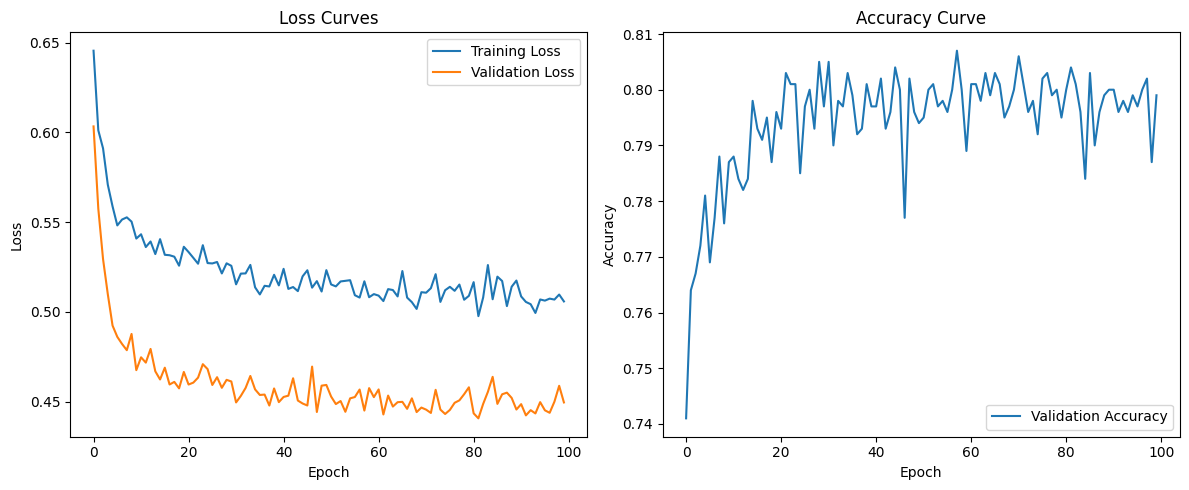


Results for AccumulationInvestment

Neural Network Metrics:
           Training   Test
accuracy      0.809  0.799
precision     0.889  0.873
recall        0.718  0.710
f1            0.794  0.783
Prédictions ajoutées : mlp_proba_AccumulationInvestment


In [ ]:
# Boucle pour chaque cible
for target in targets:
    print(f"\nTraining Enhanced MLP for: {target}")
    print("=" * 60)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)

    # Datasets & Loaders avec InvestmentDatasetFixed
    train_dataset = InvestmentDatasetFixed(X_train, y_train)
    test_dataset = InvestmentDatasetFixed(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Modèle & optimiseur
    model = MLP(input_size=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraînement avec courbes
    model = train_model_with_curves(model, train_loader, test_loader, criterion, optimizer)

    # Prédictions sur l’ensemble du dataset
    dummy_y = pd.Series(np.zeros(len(X)))  # y fictif
    full_dataset = InvestmentDatasetFixed(X, dummy_y)
    full_loader = DataLoader(full_dataset, batch_size=32)

    model.eval()
    all_proba = []

    with torch.no_grad():
        for X_batch, _ in full_loader:
            y_pred = model(X_batch).squeeze()
            all_proba.extend(y_pred.numpy())

    all_proba = np.array(all_proba)
    all_pred = (all_proba > 0.5).astype(int)
    
     # Display final metrics
    print(f"\nResults for {target}")
    print("=" * 50)

    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)

    # Ajout dans df_clients
    df_clients[f'mlp_proba_{target}'] = all_proba

    print(f"Prédictions ajoutées : mlp_proba_{target}")


In [ ]:

df_clients['Final_prediction_AccumulationInvestment'] = (
    df_clients[['reg_log_AccumulationInvestment_proba', 'xgb_proba_AccumulationInvestment', 
                'rf_proba_AccumulationInvestment', 'mlp_proba_AccumulationInvestment']]
    .mean(axis=1)
    .apply(lambda x: 1 if x >= 0.5 else 0)
)

df_clients.to_excel(
    "df_accumulation_transformed2.xlsx",
    index=False,
    sheet_name="ProcessedData"  # Optional: customize sheet name
)

NameError: name 'df_clients' is not defined